将代码分为这几个部分：函数等配置，训练1，训练2，测试。。怎么运行代码实现功能？
- 首次执行所有代码：配置，训练1，训练2，测试
- 再训练：训练2
- 再测试：测试
- 重启内核后再训练：配置，训练2
- 重启内核后再测试：配置，测试

# 配置

In [1]:
### 导包

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets 

import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [2]:
### 数据处理

In [3]:
data_dir = './flower_data/' # 数据所在目录
train_dir = data_dir + '/train' # 训练集
valid_dir = data_dir + '/valid' # 验证集

batch_size = 128 # 批次大小

In [4]:
data_transforms = {
    'train': 
    transforms.Compose([ # 按顺序执行下面的操作
        transforms.Resize([96,96]),#统一图片大小【别选太大，慢而且可能算力不够】
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选，太大了都倒着了不太合适
        transforms.CenterCrop(64),#在96×96的图片随机裁剪出64×64的。（随机裁剪得到的数据更多）
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率去翻转，0.5就是50%翻转，50%不翻转
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B【这个和上面一个不常用】
        transforms.ToTensor(),  #数据转成tensor的格式
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差（拿人家算好的）三个值对应RGB
    ]),
    'valid': # 实际应用效果以实际图像为准，不需要增强了，而且够用了，"考卷"多了也没必要
    transforms.Compose([
        transforms.Resize([64,64]), # 训练数据裁剪后最终是64的，这里直接resize到64
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #要和训练集保持一致的标准化操作
    ]),
}
  ### 【一般训练集咋做，验证集就咋做】

In [5]:
#datasets.ImageFolder 加载器 文件夹名作为文件夹下数据的标签
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# train的数据做train对应的预处理，valid同理。os.path.join(data_dir, x)<=>flower_data/train/
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}#数据加载
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']} # 训练集大小
class_names = image_datasets['train'].classes

In [6]:
### 训练配置

In [7]:
# 模型
model_name = 'resnet18'  # 可以选18、50、101、152层等 。可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']

# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 训练哪些部分
feature_extract = True # 只训练输出层

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters(): # 遍历每个参数，设置反向传播时不计算梯度，不更新参数
            param.requires_grad = False 


CUDA is available!  Training on GPU ...


In [8]:
### 训练模块函数

In [9]:
# 初始化模型函数
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet
        """
        model_ft = getattr(models, model_name)(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) # 是否冻结参数 【下面的自定义输出层没被冻上】
        num_ftrs = model_ft.fc.in_features # 查询全连接层（输出层）的输入大小
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes), # 自定义输出层，保持输入大小，输出改为102【默认要反向传播更新参数】
                                   nn.LogSoftmax(dim=1))
        input_size = 64 # 配置高可以增加

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [10]:
# 初始化模型
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True) #改成我们要训练的102类

# 最佳模型保存（网络结构+参数）
filename='best.pt'

# 存储并打印要训练哪些参数
params_to_update = model_ft.parameters() # params_to_update 列表 存储要更新的参数
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else: # else对应的逻辑是 不改变 params_to_update 列表 直接存储model_ft.parameters()
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

D:\Anaconda3\envs\study\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\envs\study\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 fc.0.weight
	 fc.0.bias


In [11]:
# 优化器设置，常用optim.Adam
optimizer_ft = optim.Adam(params_to_update, lr=1e-2) # 放入要更新的参数 ，学习率=0.01
# 衰减器
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss() # 损失函数

In [12]:
# 模型、数据、损失、优化器、迭代次数（默认25）、参数保存路径、设备
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename,device=torch.device("cpu")): 
    since = time.time() # 记录当前时间
    best_acc = 0 # 记录最好的一次准确率

    model.to(device)   #用GPU或CPU训练
    
    # 记录每次epoch的准确率和损失
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    # 获取学习率，在优化器字典对象里找
    LRs = [optimizer.param_groups[0]['lr']]
    # 把当前的参数记录下来作为初始值，后续有更好的再更新
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # 一个epoch-1个epoch来遍历【1个epoch对应多次迭代】——————————
    for epoch in range(num_epochs):
        # 打印当前执行到第几个epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证【一次epoch包括训练和验证阶段】——————————
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证
            
            # 初始化损失和正确个数
            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍【iter 迭代】————————————
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)   #将input传入GPU计算
                labels = labels.to(device)   #将labels传入GPU计算

                # 先清零再更新【梯度计算会累加上一次的epoch，不会自动清零】
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs) # 输出
                        loss1 = criterion(outputs, labels) # 计算损失
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1) # 拿到最大的输出作为预测值

                    # 只有训练阶段更新权重【训练和验证都前向传播，只有训练需要再反向传播】
                    if phase == 'train':
                        loss.backward()# 反向传播
                        optimizer.step()# 参数更新

                # 累加每次迭代的损失和正确个数
                running_loss += loss.item() * inputs.size(0) # inputs.size(0) 表示 batch
                running_corrects += torch.sum(preds == labels.data) # 统计正确个数
            
            # ————————  一次epoch的所有迭代结束 ————————————
            
            # 计算这次epoch损失和准确率
            epoch_loss = running_loss / len(dataloaders[phase].dataset) # 总损失/总数据量
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # 总正确个数/总数据量
            
            # 打印这次epoch的训练信息
            time_elapsed = time.time() - since # 耗费时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) # 损失、准确率
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc: # 更强——验证准确率更高
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # 记录当前（最好）的参数
                state = {
                  'state_dict': model.state_dict(), # 参数字典 key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc, # 准确率
                  'optimizer' : optimizer.state_dict(), # 优化器参数
                }
                torch.save(state, filename) # 保存到本地文件
                
            # 保存每次epoch的损失和准确率的历史记录
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        # ———————— 一次epoch即将结束，真正结束前再调整一下学习率 ——————————
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr'])) # 打印当前学习率
        LRs.append(optimizer.param_groups[0]['lr'])# 保存当前学习率
        print()
        scheduler.step()# 执行学习率衰减器（每n次epoch衰减一次）
    
    
    # —————————————— 所有epoch结束，训练完成 ————————————————
    
    time_elapsed = time.time() - since # 训练耗费总时间
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc)) # 最佳准确率

    # 训练完后 用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts) # 加载记录好的最佳参数
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs # 返回 最佳模型、历史损失和正确率、学习率


# 训练1

In [14]:
model_ft,val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model( # 调用训练函数模块
model_ft, # 模型
dataloaders, # 加载器
criterion, # 损失
optimizer_ft, # 优化器
num_epochs=20, # 次数
is_inception=(model_name=="inception")) 

Epoch 0/19
----------


KeyboardInterrupt: 

# 训练2

In [ ]:
### 修改配置

In [ ]:
# 将所有参数解冻
for param in model_ft.parameters():
    param.requires_grad = True  

# 优化器需要更新所有参数，学习率调小一点
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)  
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)  

# 损失函数
# criterion = nn.NLLLoss()  # 注意：由于你使用了 LogSoftmax，应该继续使用 NLLLoss

In [ ]:
# Load the checkpoint 加载之前训练好的模型【进程结束后，内存就没有训练好的模型了】

checkpoint = torch.load(filename) # 从文件获取模型
best_acc = checkpoint['best_acc'] # 将之前的最佳准确率作为初始值
#【bug吧，因为训练函数一进去就会把它初始化为0，也就是说第一次epoch后才会记录，漏掉了第0次也就是初始模型万一就是最佳的情况。不过这个无所谓】
model_ft.load_state_dict(checkpoint['state_dict']) # 加载模型
# optimizer.load_state_dict(checkpoint['optimizer'])
# model_ft.class_to_idx = checkpoint['mapping']

In [ ]:
# 开始训练
model_ft,val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(
model_ft,
dataloaders,
criterion,
optimizer_ft,
num_epochs=20, 
is_inception=(model_name=="inception"))

# 测试

In [13]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='resnet18.pt'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc'] # 有bug，第二次训练的代码也有这个
#【bug吧，因为训练函数一进去就会把它初始化为0，也就是说第一次epoch后才会记录，漏掉了第0次也就是初始模型万一就是最佳的情况。不过这个无所谓】
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [162]:
# 迭代器，一次获取一个batch的测试数据，next获取下一个【下次运行就是下一批数据了】
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False) for x in ['train', 'valid']}#数据加载
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.__next__()  # 获取图像+标签 【Pytorch版本更新：next改为__next__】

# 验证模式，不做更新
model_ft.eval()

# 数据传入cuda还是直接传
if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [163]:
output.shape,output

(torch.Size([128, 102]),
 tensor([[ -1.4622, -34.6986, -22.7238,  ...,  -6.9782, -17.4933, -21.2232],
         [ -3.6209, -42.0301, -30.9308,  ..., -11.7216, -12.1968, -31.9732],
         [ -0.1186, -49.0684, -40.6397,  ..., -12.9645, -18.0140, -36.0927],
         ...,
         [-19.9773, -19.7219, -23.0171,  ...,  -7.0752, -13.9422, -20.2353],
         [-22.8201, -21.4682, -22.9749,  ..., -14.0248, -19.5540, -22.6359],
         [-30.0959, -29.6751, -25.7486,  ..., -17.0923, -22.1231, -20.0917]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward0>))

In [164]:
_, preds_tensor = torch.max(output, 1) # 得到概率最大的类别
# 用gpu还得先取到cpu再将tensor转成数组adarray形式【画图matplotlib只支持数组】【torch对应tensor对应gpu，numpy对应cpu】
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy()) 
preds,preds+1 # 一个批次的预测结果

(array([ 50,  61,   0,   0,  53,  61,   5,  51,   1,   1,   1,   1,   2,
         71,   2,   2,   2,   2,   3,   3,   3,   3,   3,   4,   4,   4,
          4,   4,   4,  20,  23,  96,   5,  20,  87,  49,  19,   5,  96,
          6,   6,  64,   6,   6,   7,   7,  24,   7,   7,  25,   9,   9,
          9,   9,   9,   9,   9,  10,  10,  77,  65,  11,  11,  65,  65,
         11,  11,  11,  11,  11,  11,  11,  11,  65,  11,  64,  12,  82,
         12,  90,  85,  57,  12,  85,  85,  40,  83,  24,  13, 100,  14,
         14,  14,  14,  14,  14,  15,  15,  66,  15,  97,  15,  15,  16,
         16,  16,  16,  17,  17,  17,  17,  17,  94,  17,  17,  18,  53,
         18,  16,  18,  18,  18,  85,  53,  18,  18,  18,  19], dtype=int64),
 array([ 51,  62,   1,   1,  54,  62,   6,  52,   2,   2,   2,   2,   3,
         72,   3,   3,   3,   3,   4,   4,   4,   4,   4,   5,   5,   5,
          5,   5,   5,  21,  24,  97,   6,  21,  88,  50,  20,   6,  97,
          7,   7,  65,   7,   7,   8,   8,  25

In [165]:
mapping = [
    1, 10, 100, 101, 102, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24,
    25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42,
    43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60,
    61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
    8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97,
    98, 99
] # 类别0~101要对应文件夹序号1~102

In [166]:
images.shape

torch.Size([128, 3, 64, 64])

In [167]:
### 展示
labels

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  9,  9,  9,  9,
         9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
        14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17,
        17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 19])

In [168]:
preds = torch.tensor(mapping)[preds] # 将preds作为索引得到map(先转成tensor)元素
labels = torch.tensor(mapping)[labels]
preds,labels

(tensor([ 52,  62,   1,   1,  55,  62,  11,  53,  10,  10,  10,  10, 100,  71,
         100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102,
         102,  25,  28,  94,  11,  25,  86,  51,  24,  11,  94,  12,  12,  65,
          12,  12,  13,  13,  29,  13,  13,   3,  15,  15,  15,  15,  15,  15,
          15,  16,  16,  77,  66,  17,  17,  66,  66,  17,  17,  17,  17,  17,
          17,  17,  17,  66,  17,  65,  18,  81,  18,  89,  84,  59,  18,  84,
          84,  43,  82,  29,  19,  98,   2,   2,   2,   2,   2,   2,  20,  20,
          67,  20,  95,  20,  20,  21,  21,  21,  21,  22,  22,  22,  22,  22,
          92,  22,  22,  23,  55,  23,  21,  23,  23,  23,  84,  55,  23,  23,
          23,  24]),
 tensor([  1,   1,   1,   1,   1,   1,   1,   1,  10,  10,  10,  10, 100, 100,
         100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102,
         102,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  12,  12,  12,
          12,  12,  13,  13,  1

In [169]:
with open('cat_to_name.json', 'r') as f: # json文件以字典存放文件夹编号和花卉名称的对应关系【用于最后名称展示】
    cat_to_name = json.load(f) 

In [170]:
# 图像数据转换成原格式
def im_convert(tensor):
    """展示数据"""
    # 利用torch的dataloader取得，tensor结构，需要转到cpu转换成数组格式
    image = tensor.to("cpu").clone().detach() 
    image = image.numpy().squeeze() # squeeze()压缩

    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) # 防止数值越界或异常
    return image

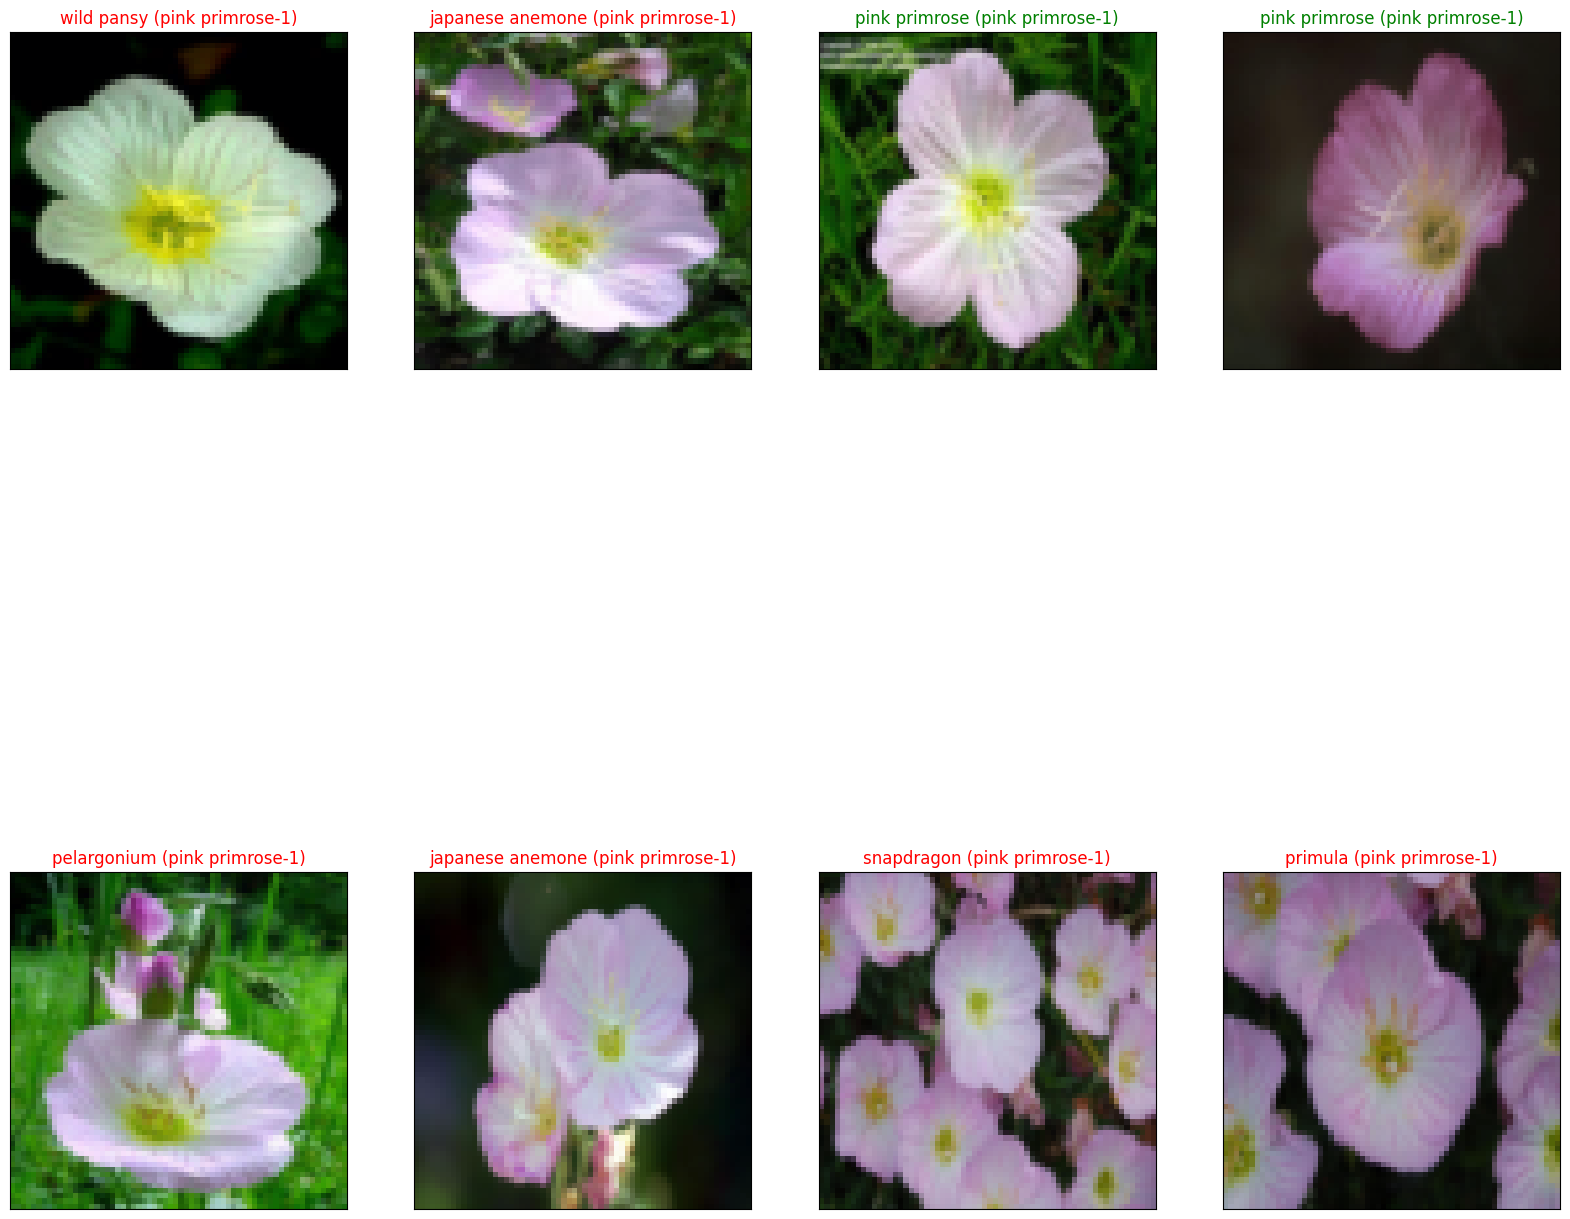

In [171]:
fig=plt.figure(figsize=(20, 20)) # 单个画布大小：20×20
columns =4
rows = 2

for idx in range (columns*rows): # 展示4×2个图像
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    # 利用json得到数字对应的花卉名称。预测正确绿色，错误为红色 格式：预测(实际)
    ax.set_title("{} ({}-{})".format(cat_to_name[str(preds[idx].item())], cat_to_name[str(labels[idx].item())],labels[idx].item()), 
                 color=("green" if cat_to_name[str(preds[idx].item())]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show() # 开始展示


索引修正

例如：要把这个tensor利用map转换

tensor([0,1,2,3 ])

map = [1,10,100,101,102,11,12,13,14,15] # tensor元素作为索引，将对应列表元素作为新的tensor元素

得到：

tensor([1,10,100,101 ])

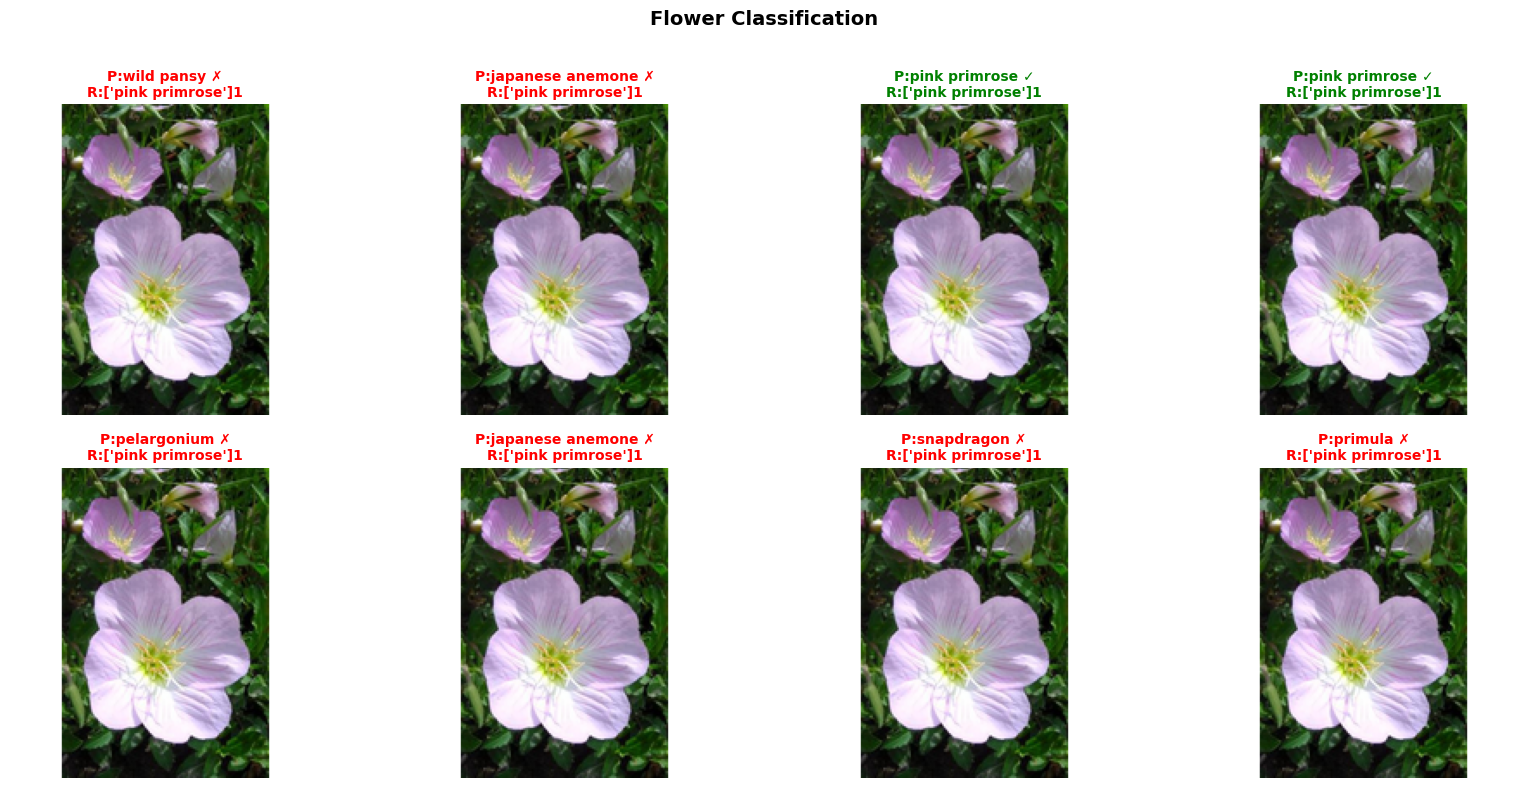


显示样本统计:
正确预测: 2/8
准确率: 25.0%


In [172]:
def get_unified_original_images(batch_images, batch_indices, dataset=image_datasets['valid'], target_size=(180, 180)):
    """获取原始图片并统一尺寸"""
    unified_images = []

    # 遍历当前批次中的每个样本
    for i in range(len(batch_indices)):
        # dataset.imgs 存储所有图片的 (路径, DataLoader类别索引)
        # batch_indices[i] 是第i个样本在DataLoader中的位置索引
        img_path = dataset.imgs[batch_indices[i]][0]  # 获取图片文件路径

        # 使用PIL库打开原始图片文件
        original_img = Image.open(img_path)

        # 保持宽高比调整尺寸
        original_img.thumbnail(target_size, Image.Resampling.LANCZOS)

        # 创建目标尺寸的画布（白色背景）
        unified_img = Image.new('RGB', target_size, (255, 255, 255))

        # 计算居中位置
        x = (target_size[0] - original_img.size[0]) // 2
        y = (target_size[1] - original_img.size[1]) // 2

        # 将缩放后的原始图片粘贴到白色画布上
        unified_img.paste(original_img, (x, y))
        unified_images.append(unified_img)

    return unified_images


# 获取统一尺寸的图片 - 使用更小的尺寸
unified_imgs = get_unified_original_images(images, labels.cpu().numpy(), target_size=(180, 180))

### 优化布局显示 - 更紧凑的布局
fig = plt.figure(figsize=(16, 8))  # 减小画布尺寸
columns = 4
rows = 2

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1)

    # 显示统一尺寸的图片
    ax.imshow(unified_imgs[idx])
    ax.axis('off')

    # 获取预测和真实标签
    pred_label = cat_to_name[str(preds[idx].item())]
    true_label = cat_to_name[str(labels[idx].item())]

    # 判断是否正确
    is_correct = (preds[idx].item() == labels[idx].item())
    color = "green" if is_correct else "red"

    result = ""
    if is_correct:
        result += " ✓"
    else:
        result += " ✗"

    # 简化标题显示
    title_text = f"P:{pred_label}{result}\nR:{[true_label]}{labels[idx].item()}"


    ax.set_title(title_text,
                 color=color,
                 fontsize=10,  # 减小字体
                 fontweight='bold',
                 pad=6,  # 减小间距
                 linespacing=1.2)

# 添加总体标题
plt.suptitle('Flower Classification',
             fontsize=14,  # 减小标题字体
             fontweight='bold',
             y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0, w_pad=2.0)  # 增加子图间距
plt.show()

# 打印统计信息
correct_count = sum(preds[:columns * rows] == labels.cpu().numpy()[:columns * rows])
print(f"\n显示样本统计:")
print(f"正确预测: {correct_count}/{columns * rows}")
print(f"准确率: {correct_count / (columns * rows) * 100:.1f}%")